In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [6]:
# define the start date, end date, as well as stock symbol
start = '2018-01-01'
end = '2024-12-31'
stock= 'GOOG'

In [8]:
# Download historical stock data using the Yahoo Finance API (yfinance)
# stock: ticker symbol of the stock you're interested in, "AAPL" for Apple, "GOOG" for google
# start: the starting date of the data range (ex: Jan 1, 2018)
# end: the edn date of the data range (ex: Dec 31, 2024)
data = yf.download(stock, start , end)

# reset the index of the dataframe so that the date becomes a regular column instead of the index
data.reset_index(inplace=True)

# Drop any rows with missing data from the dataset
data.dropna(inplace= True)

# Display the stock price data chart
data

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2018-01-02,53.059353,53.156006,52.074393,52.229335,24752000
1,2018-01-03,53.930225,54.120042,52.970174,53.024977,28604000
2,2018-01-04,54.125519,54.482737,54.006048,54.205234,20092000
3,2018-01-05,54.914188,55.014829,54.404518,54.504163,25582000
4,2018-01-08,55.148846,55.364570,54.883799,54.914188,20952000
...,...,...,...,...,...,...
1755,2024-12-23,195.990005,196.490005,191.630005,194.029999,15235900
1756,2024-12-24,197.570007,197.669998,195.197998,196.169998,6809800
1757,2024-12-26,197.100006,198.160004,195.869995,196.740005,7907900


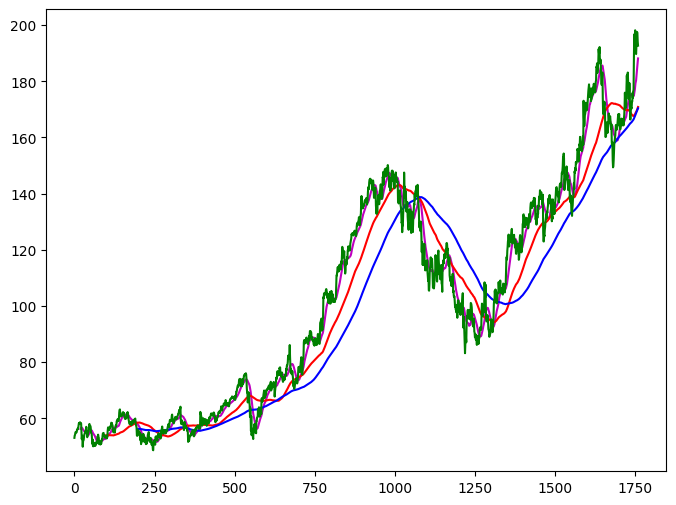

In [16]:
# Calculate the moving average for the stock's CLOSING price
# .rolling(100): Creates a rolling window of 100 days
# .mean(): Calculates the average over 100-day window for each point

# 20 days is good for looking at short-term changes
ma_20_days = data.Close.rolling(20).mean()

# 100 days is good for looking at medium-term changes
ma_100_days = data.Close.rolling(100).mean()

# 200 days is good for looking at long-term changes
ma_200_days = data.Close.rolling(200).mean()

plt.figure(figsize=(8,6))

plt.plot(ma_20_days, 'm')
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [17]:
# Split the data into training and testing datasets. 
# The first 80% (older data) is used for training because it reflects the historical patterns the model needs to learn
# The last 20% (most recent data) is reserved for testing because it mimics the real-world scenario where we evaluate the model on future data.

# The training dateset is the first 80% of the stock's closing price data
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])

# The testing dataset is the last 20% of the stock's closing price data
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

# display the number of rows in the training dataset
data_train.shape[0]

# display the number of rows in the testing dataset
data_test.shape[0]

352

In [18]:
# Import MinMaxScaler to scale data to a range between 0 and 1.
# This is essential for LSTM models since they are sensitive to the scale of input data.
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler with a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fits the data to data_train and transforms it, normalizing each value to the specified range.
data_train_scale = scaler.fit_transform(data_train)

# The goal is to create a dataset where the model learns from sequences of 100 data points to predict the 101st point.
x = [] # Contains sequences of 100 scaled data points (e.g. rows 0-99, 1-100, 2-101 etc)
y = [] # Contains the corresponsing target values (e.g. 100, 101, 102, etc)

# Iterates from 100 to the total number of rows in data_train_scale
# 100 is a good starting point as it provides enough info without overwhelming the model
for i in range(100, data_train_scale.shape[0]):
    # Append the last 100 data points to x
    x.append(data_train_scale[i - 100:i])
    
    # Append the next data point (target) to y
    y.append(data_train_scale[i, 0])

# LSTM models in TensorFlor/Keras require input and target data to be in NumPy array format.
x, y = np.array(x), np.array(y)

# Import necessary modules from TensorFlow/Keras to define the model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential

In [19]:
# Create a Sequential model, which is a linear stack of layers.
# Add layers to the model one by one, and data flows through them in order.
model = Sequential()

# Add an Input layer to define the input shape
# x.shape[1] is the number of time steps in your input data (e.g 100 data points from the time-series sequence)
# 1 represents the number of features per time step (e.g the stock price value)
model.add(Input(shape=(x.shape[1], 1)))

# Adds a Long Short-Term Memory layer to the model
# LSTM is designed for time-series or sequential data. It helps the model remember long-term dependencies in the data, which is crucial for stock prediction
# units = 50: specifies 50 units in the LSTM layer, which menas it can learn 50 features or patterns from the data
# activation = 'relu': uses the ReLU (Rectified Linear Unit) activation function, which helps the model learn non-linear patterns efficiently
# return_sequences = True: ensures the LSTM layer outputs a sequence instead of a single value. This is important when stacking LSTM layers.
model.add(LSTM(units=50, activation='relu', return_sequences=True))

# Add a Dropout layer to prevent overfitting, which randomly sets 20% of the neurons to 0 during training
# Dropout reduced overfitting by preventing the model from relying too heavily on specific neurons, encouraging it to generalize better.
model.add(Dropout(0.2))

In [20]:
# Adds a 2nd LSTM layer to the model
# units = 60: specifies 60 units in the LSTM layer, which menas it can learn 60 features or patterns from the data
# activation = 'relu': uses the ReLU (Rectified Linear Unit) activation function, which helps the model learn non-linear patterns efficiently
# return_sequences = True: ensures the LSTM layer outputs a sequence instead of a single value. This is important when stacking LSTM layers.
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))

# Add a Dropout layer to prevent overfitting, which randomly sets 30% of the neurons to 0 during training
model.add(Dropout(0.3))

In [21]:
# Adds a 3rd LSTM layer to the model
# units = 80: specifies 80 units in the LSTM layer, which menas it can learn 80 features or patterns from the data
# activation = 'relu': uses the ReLU (Rectified Linear Unit) activation function, which helps the model learn non-linear patterns efficiently
# return_sequences = True: ensures the LSTM layer outputs a sequence instead of a single value. This is important when stacking LSTM layers.
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))

# Add a Dropout layer to prevent overfitting, which randomly sets 40% of the neurons to 0 during training
model.add(Dropout(0.4))

In [22]:
# Adds a 4th LSTM layer to the model
# units = 120: specifies 120 units in the LSTM layer, which menas it can learn 120 features or patterns from the data
# activation = 'relu': uses the ReLU (Rectified Linear Unit) activation function, which helps the model learn non-linear patterns efficiently
model.add(LSTM(units = 120, activation = 'relu'))

# Add a Dropout layer to prevent overfitting, which randomly sets 50% of the neurons to 0 during training
model.add(Dropout(0.5))

In [23]:
# Adds a dense layer of 1 unit, which produces the final output of the model (predicted stock price)
model.add(Dense(units = 1))

In [25]:
# adam: (Adaptive Movement Estimation) is an advanced optimization algorithm that adjusts the learning rate for each paramater.
# combines the benefits of both AdaGrad and RMSProp, adapting the learning rate based on the gradient and moving averages of past gradients.

# mean_squared_error: loss function typically used for regression tasks (predicting continuous values like stock prices)
# measures the average squared difference between the predicted values and the actual values
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
# x: 
# y: 
# epochs: The number of epochs determines how many times the model will iterate over the training dataset. 50 is the starting point for training deep learning models.
# batch_size: the number of training samples used in one forward/backward pass through the model. Determines how much data is processed before the model's weights are updated.
# verbose=1: progress bar for each epoch. displays the training loss. smaller loss value each time means the model is training better.
model.fit(x, y, epochs = 50, batch_size = 32, verbose=1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0039
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0040
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0046
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0043
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0038
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0039
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0038
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0036
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.0039
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0038
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0036
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0033
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0032
Epoch 14/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0036
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - lo

In [28]:
# the function in Keras provides a summary of the model architecture.
# it displays the layer type, the output shape, and the number of params
# It also displays the total params, the trainable params, the non-trainable params, and the optimizer params
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [29]:
# this function gets the last 100 rows of the data_train dataframe.
# presumably represents the last 100 stock price entries from the training data
# using the last 100 data points to predict the next stock price
past_100_days = data_train.tail(100)

In [30]:
# appends the past_100_days data to the beginning of the data_test frame.
# ensures that when making predictions, you will use the most recent 100 days from data_train combined with the data from data_test
# provides a continuous sequence for input to the model
data_test = pd.concat([past_100_days, data_test], ignore_index = True)

In [31]:
# 
data_test_scale = scaler.fit_transform(data_test)

In [32]:
x = []
y = []
for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i - 100:i])
    y.append(data_test_scale[i, 0])
x, y = np.array(x), np.array(y)

In [33]:
y_predict = model.predict(x)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [34]:
scale = 1/scaler.scale_

In [35]:
y_predict = y_predict*scale

In [36]:
y = y*scale

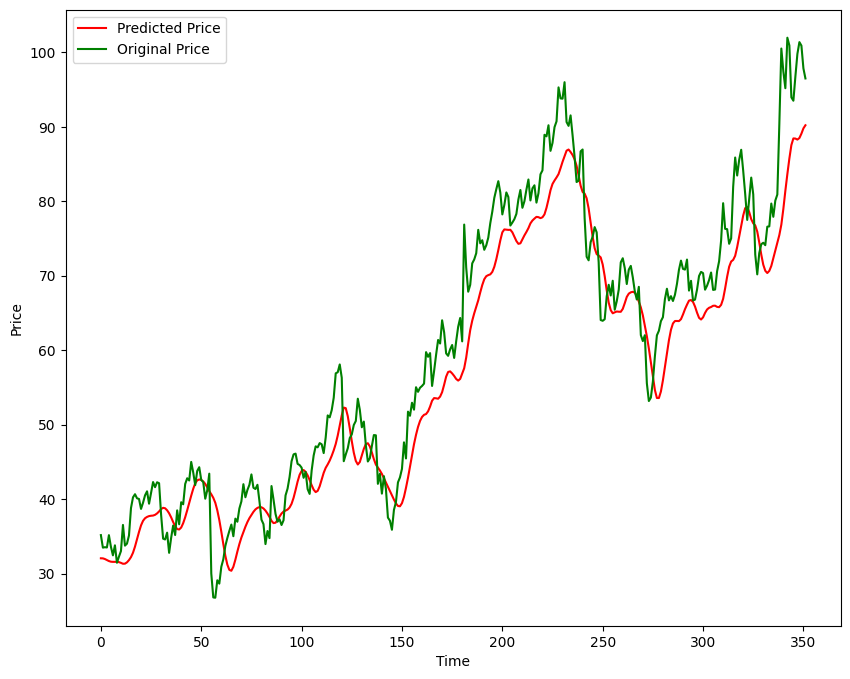

In [37]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
model.save('Stock Predictions Model.keras')